# Importing the needed libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline
sns.set()

# The current state of the art performance for this dataset is 99 accuracy (GPipe: Efficient Training of Giant Neural Networks using pipeline parallelism)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
# Setting random seed for reproducible results

from tensorflow.python.client import device_lib 

np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4684316816424207863
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416432436
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2852806309567360068
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Importing the cifar 10 dataset
- Data downloaded from https://www.cs.toronto.edu/~kriz/cifar.html

In [87]:
image_size = 32
num_channels = 3
image_size_flat = image_size * image_size * num_channels
num_classes = 10
train_files = 5
image_per_file = 10000
num_train_images = 50000

# functions for processing raw cifar file from memory


# change the raw data to float and normalize them by dividing by the highest pixel value 255
def convert(raw):
    raw_float = np.array(raw, dtype=float)
    #reshape into 4 dimensions
    images = raw_float.reshape(-1, num_channels, image_size, image_size)
    # reorder image shape indices
    images = images.transpose([0,2,3,1])
    return images

# load pickle files and return the images and class label
def load(filename):
    #load pickle files
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    
    # get raw images and label
    raw_images = data[b'data']
    labels = np.array(data[b'labels'])
    
    # convert the images
    images = convert(raw_images)
    
    return images, labels

# load the name of the classes in the cifar-10 dataset
def load_class_names():
    with open('data/batches.meta', 'rb') as f:
        raw = pickle.load(f, encoding='bytes')[b'label_names']
    
    # convert from binary strings to strings
    names = [x.decode('utf-8') for x in raw]
    
    return names

# Load all the 5 batch files of the cifar 10 dataset and combine them in a single training dataset
def load_train_data():
    # create placeholder image and label arrays
    images = np.zeros(shape=[num_train_images, image_size, image_size, num_channels], dtype='float')
    labels = np.zeros(shape=[num_train_images], dtype='int')
    
    # begin index for the current batch
    begin = 0
    
    # for each data file
    for i in range(train_files):
        # load images and labels
        image_batch, label_batch = load('data/data_batch_' + str(i+1))
        
        # number of images for this batch
        num_images = len(image_batch)
        
        # End-index for the current batch
        end = begin + num_images
        
        # store images in an array
        images[begin:end, :] = image_batch
        
        # store the labels in an array
        labels[begin:end] = label_batch
        
        # the begin index is for the next batch is the current end-index
        begin = end
        
    return images, labels, OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))


# load test data
def load_test_data():
    images, labels = load('data/test_batch')
    
    return images, labels, OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))        

In [88]:
# load data

X_train, y_train, y_train_oh = load_train_data()
X_test, y_test, y_test_oh = load_test_data()
classes = load_class_names()

In [83]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
# Alternatively

#(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [8]:
y_train

array([6, 9, 9, ..., 9, 1, 1])

In [9]:
y_train.shape, y_train_oh.shape

((50000,), (50000, 10))

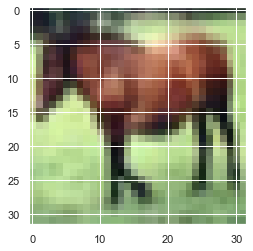

In [10]:
x = X_train.copy()/255

plt.imshow(x[7])

In [11]:
y_train.shape

(50000,)

In [12]:
y_train[4]

1

In [13]:
# Reshaping y_train, and y_test
y_train1 = y_train.reshape(-1,)


deer


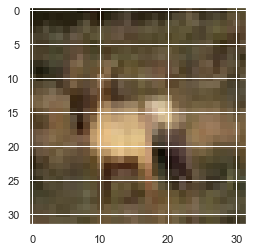

In [14]:
print(classes[y_train[3]])
plt.imshow(x[3])

# After investigating the images,  we can say that the images would benefit from horizontal flip and random brightness data augmentations

In [89]:
# Normalising the values by dividing by the maximum pixel value (255) if you loaded data from tensorflow library

X_train =  X_train/255
X_test = X_test/255


## Use sklearn split the training data into train / validate datasets

In [90]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in ss.split(X_train, y_train_oh):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train_oh[train_index], y_train_oh[test_index]

In [91]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 10), (5000, 10))

### use the X_val and y_val as validation data

# Training models on the train and test data

## Using an Artificial Neural Network

In [92]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(3072, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train,  validation_data=[X_val, y_val], epochs=40, callbacks=[es])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_54 (Dense)             (None, 10)                10250     
Total params: 12,597,258
Trainable params: 12,597,258
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 5000 samples
Epoch 1/40
45000/45000 [==============================] - 19s 429us/sample - loss: 1.8733 - accuracy: 0.3294 - val_loss: 2.2020 - val_accuracy: 0.2298
Epoch 2/40
45000/45000 [==========

In [94]:
model.evaluate(X_test, y_test_oh) 

10000/10000 [==============================] - 2s 207us/sample - loss: 1.5203 - accuracy: 0.4728


[1.5202577260971069, 0.4728]

In [17]:
pred = model.predict(X_test)
pred = [np.argmax(x) for x in pred]
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.56      1000
           1       0.80      0.31      0.45      1000
           2       0.34      0.55      0.42      1000
           3       0.32      0.31      0.31      1000
           4       0.69      0.12      0.21      1000
           5       0.36      0.50      0.42      1000
           6       0.46      0.70      0.55      1000
           7       0.51      0.65      0.57      1000
           8       0.79      0.49      0.60      1000
           9       0.50      0.64      0.56      1000

    accuracy                           0.48     10000
   macro avg       0.54      0.48      0.47     10000
weighted avg       0.54      0.48      0.47     10000



[[498   8 183  32   1  47  55  66  55  55]
 [ 40 309  30  65   2  34  63  50  34 373]
 [ 33   3 547  75  16 104 120  87   3  12]
 [  5   2 106 308   5 312 171  64   6  21]
 [ 21   2 347  63 124 106 183 137   7  10]
 [  5   1 140 173   6 50

## The artificial neural network preformed poorly on the test data getting 48 percent accuracy. It performed best on class 8 (ship) and worst on class 4 (deer). Next we would try a convolution neural network which is more suited to images

# Convolution Neural Network

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True)

# zca_whitening=True

#datagen.fit(X_train, seed=42)

In [100]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
cnn = Sequential()

# data augumentation
# cnn.add(preprocessing.RandomFlip('horizontal')) # flip left to right
# cnn.add(preprocessing.RandomContrast(0.5)) # contrast change by up to 50%

# convolution layer
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               padding='same', input_shape=(32, 32, 3)))
cnn.add(MaxPool2D((2, 2)))

cnn.add(Conv2D(filters=32, kernel_size=(3, 3),
               activation='relu', padding='same'))
cnn.add(MaxPool2D((2, 2)))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3),
               activation='relu', padding='same'))
cnn.add(MaxPool2D((2, 2)))

# DNN classifier layer
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))

# cnn.add(BatchNormalization())

cnn.add(Dense(10, activation='softmax'))

print(cnn.summary(), '\n')

cnn.compile(loss='categorical_crossentropy',
            optimizer='adam', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
cnn.fit(X_train, y_train, batch_size=128, validation_data=[X_val, y_val], callbacks=[es], epochs=40)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1024)            

In [101]:
cnn.evaluate(X_test, y_test_oh)

10000/10000 [==============================] - 2s 203us/sample - loss: 0.9532 - accuracy: 0.7284


[0.9532061398506164, 0.7284]

## Results
- CNN Base Accuracy: 0.7165, loss: 0.9423 (with valid padding) 
- with same padding, Accuracy: 0.7498 , loss: 1.1980

In [77]:
pred = cnn.predict(X_test)

for x in pred:
    for y in x:
        check = 0
        if y > 0:
            check=y
    x = x/check

pred

array([[9.0831444e-03, 6.2974142e-03, 4.1727073e-02, ..., 1.3908591e-02,
        4.9401369e-02, 3.7941639e-03],
       [9.7291086e-06, 9.9668568e-01, 1.3140768e-11, ..., 1.4708816e-12,
        1.6313447e-02, 2.2943712e-05],
       [9.1973983e-02, 4.5206195e-01, 7.2195871e-05, ..., 9.8815850e-05,
        1.0513750e-01, 2.6250675e-01],
       ...,
       [1.4018295e-07, 1.7940168e-08, 2.0776486e-01, ..., 1.0609363e-02,
        7.5108817e-09, 1.4930369e-07],
       [1.0560503e-03, 1.4082702e-01, 7.4496299e-02, ..., 9.7728455e-03,
        7.3303767e-05, 1.6160958e-04],
       [5.7247003e-09, 3.8489226e-08, 6.2935928e-06, ..., 9.9653107e-01,
        5.1231388e-09, 1.1388489e-08]], dtype=float32)

In [80]:
pred1 = cnn.predict(X_test)
cnn.
#y_test_oh = [np.argmax(x) for x in y_test_oh]
pred1 = [np.argmax(x) for x in pred]
print(classification_report(y_test, pred1))
print('\n')
print(confusion_matrix(y_test, pred1))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1000
           1       0.83      0.85      0.84      1000
           2       0.58      0.70      0.63      1000
           3       0.61      0.49      0.54      1000
           4       0.73      0.63      0.67      1000
           5       0.63      0.67      0.65      1000
           6       0.88      0.71      0.79      1000
           7       0.74      0.81      0.77      1000
           8       0.81      0.86      0.83      1000
           9       0.84      0.79      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



[[813  18  43   9   9   9   6  15  57  21]
 [ 16 852  12   8   3   6   4   2  34  63]
 [ 82   5 699  33  57  52  18  31  16   7]
 [ 40  14 105 495  50 185  27  46  20  18]
 [ 36   6 115  55 629  34  19  94  10   2]
 [ 18   5  83 104  28 67

## What i noticed is that our cnn classifier performed much better than our ann classifier(71 percent vs 48 percent accuracy). It also performed better on certain image classes and less on others
- It performed best on image class 1 (automobile)
- it performed performed the least on image class 3 (cat)

Comparing the two models,  they both performed well on class 8(ship) and poorly on class 3(cat)

# Using transfer learning with VGG16 model

In [104]:
# Reload the data

X_train, y_train, y_train_oh = load_train_data()
X_test, y_test, y_test_oh = load_test_data()

# Preprocess the data

def preprocess(X, y):
    X = X.astype('float32')
    #using preprocess VGG16 method by default to scale images and their values
    X = preprocess_input(X)
    # changind labels to one-hot representation
    y = tf.keras.utils.to_categorical(y, 10)
    return (X, y)

X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in ss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train_oh[train_index], y_train_oh[test_index]

y_test.shape

(10000, 10)

In [103]:
# load the base of vgg16

pt_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

#pt_base.trainable = False

In [106]:
# attach the head

tf_model = Sequential()
tf_model.add(tf.keras.layers.UpSampling2D())

tf_model.add(pt_base)

tf_model.add(Flatten())

tf_model.add(Dense(512, activation='relu'))
tf_model.add(Dropout(0.2))
#tf_model.add(BatchNormalization())

tf_model.add(Dense(256, activation='relu'))
tf_model.add(Dropout(0.2))
#tf_model.add(BatchNormalization())

tf_model.add(Dense(10, activation='softmax'))

#print(tf_model.summary())

tf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
tf_model.fit(X_train, y_train, batch_size=128, validation_data=[X_val, y_val], callbacks=[es], epochs=40)

Train on 45000 samples, validate on 5000 samples
Epoch 1/40
45000/45000 [==============================] - 467s 10ms/sample - loss: 2.2705 - accuracy: 0.1771 - val_loss: 1.8703 - val_accuracy: 0.2336
Epoch 2/40
45000/45000 [==============================] - 466s 10ms/sample - loss: 1.6295 - accuracy: 0.3630 - val_loss: 1.2693 - val_accuracy: 0.5286
Epoch 3/40
45000/45000 [==============================] - 467s 10ms/sample - loss: 1.2065 - accuracy: 0.5622 - val_loss: 0.9604 - val_accuracy: 0.6532
Epoch 4/40
45000/45000 [==============================] - 466s 10ms/sample - loss: 0.9688 - accuracy: 0.6586 - val_loss: 0.9250 - val_accuracy: 0.6704
Epoch 5/40
45000/45000 [==============================] - 462s 10ms/sample - loss: 0.8206 - accuracy: 0.7166 - val_loss: 0.7710 - val_accuracy: 0.7252
Epoch 6/40
45000/45000 [==============================] - 462s 10ms/sample - loss: 0.7140 - accuracy: 0.7565 - val_loss: 0.7787 - val_accuracy: 0.7444
Epoch 7/40
45000/45000 [=====================

In [107]:
tf_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 39s 4ms/sample - loss: 0.7992 - accuracy: 0.7999


[0.7992437379837036, 0.7999]

# Result
- using a pretrained base - accuracy: 0.9413, loss: 0.1659
- using an untrained base - accuracy: 0.80, loss: 0.80

In [109]:
pred2 = tf_model.predict(X_test)

pred2 = [np.argmax(x) for x in pred2]

print(classification_report(y_test, pred2))
print('\n')
print(confusion_matrix(y_test, pred2))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [61]:
#pred2 = tf_model.predict(X_test)
pred2[:5]

array([[2.4638460e-03, 4.7984677e-03, 6.9234386e-02, 8.8135773e-01,
        2.9722152e-03, 8.5631832e-02, 1.9329368e-03, 4.8492029e-03,
        2.9388447e-03, 8.5422471e-03],
       [1.9221329e-06, 6.6483831e-06, 1.7318740e-11, 1.5293489e-09,
        1.0368213e-11, 1.3760970e-09, 8.2767448e-10, 7.4970976e-13,
        9.9999678e-01, 2.1126366e-06],
       [1.0045807e-07, 1.0694215e-07, 4.3051267e-11, 1.8041608e-07,
        1.0883047e-08, 1.4120174e-09, 5.0609461e-11, 1.1546304e-10,
        9.9999964e-01, 1.7983822e-07],
       [9.9459249e-01, 2.6554329e-04, 5.2526998e-06, 5.7255529e-05,
        6.8589194e-05, 1.4273588e-05, 4.1288608e-06, 4.9162081e-06,
        9.0581095e-03, 2.6577491e-02],
       [1.5259470e-06, 1.8828603e-05, 8.5450336e-03, 6.3157082e-03,
        2.1594062e-03, 2.4105785e-04, 9.7402829e-01, 1.1041429e-05,
        2.7482001e-06, 3.0972474e-06]], dtype=float32)

In [65]:
y_test_oh

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])